# 1.3 Agentic RAG (feat. conditional edge)

- `conditional_edge`를 활용하는 방법을 배웁니다
    - `conditional_edge`는 `LangGraph`에서 조건부 실행 흐름을 제어하는 엣지입니다. 
    - 일반 `edge`와 달리, 특정 조건이 충족될 때만 해당 경로로 실행이 진행됩니다.
- `conditional_edge`는 주로 'if-then' 형태의 로직을 구현할 때 사용됩니다. 
    - 사용자의 입력이 특정 조건을 만족할 때만 특정 `node`로 이동하고, 그렇지 않으면 다른 경로로 진행하도록 설정할 수 있습니다

### Agentic RAG Architecture
![agentic-rag](https://i.imgur.com/9NCNGWa.png)

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'chroma_collection',
    persist_directory = './chroma_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

- `state`를 선언하고 에이전트를 생성합니다
- 1.2와 같이 RAG 파이프라인 구성이 목적이기 때문에 동일한 `state`를 사용합니다

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [4]:
from langchain_classic import hub
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.
    
    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})

    print("Generate: ", response.content)
    return {'answer': response}

- `conditional_edge`를 활용하여 문서 관련성을 판단하는 로직을 구현합니다
    - 에이전트는 LLM의 판단과 의사결정을 따릅니다

In [5]:
from langchain_classic import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옵니다.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    context = state['context']  # state에서 문맥을 추출합니다.

    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm
    
    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print("Check Doc Relevance: ", response['Score'])

    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['차량 소유자 -> 자동차 소유자']

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    
    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({'query': query})
    print("Rewrite Query: 기존 질문", query, "-> 변경 질문", response)
    
    return {'query': response}

- `node`를 추가하고 `edge`로 연결합니다

In [7]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [8]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')

graph_builder.add_conditional_edges('retrieve', 
check_doc_relevance,
{
    'generate': 'generate',
    'rewrite': 'rewrite'
})
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [9]:
graph = graph_builder.compile()

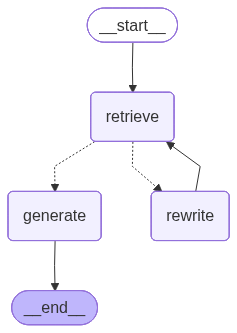

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
initial_state = {'query': '나 차 있는데 괜찮아?'}
graph.invoke(initial_state)

Check Doc Relevance:  0
Rewrite Query: 기존 질문 나 차 있는데 괜찮아? -> 변경 질문 질문: 나 자동차 소유자인데 괜찮아?
Check Doc Relevance:  1
Generate:  자동차 소유자의 경우, 차량가액이 2,500만원 이상이면 청년 월세 지원금을 신청할 수 없습니다. 만약 자동차가 이 기준에 해당된다면 지원 대상에서 제외됩니다. 자격 요건을 재검토하시는 것이 필요합니다.


{'query': '질문: 나 자동차 소유자인데 괜찮아?',
 'context': [Document(id='aadb18b4-21b6-4b81-b6a1-40ae352ba708', metadata={'source': './documents/청년월세지원.txt'}, page_content='○ (연령) 19세~39세 이하 (주민등록등본상 1985. 1. 1. ~ 2006. 12. 31.)\n○ (거주) 임차보증금 8천만원 이하면서 월세 60만원 이하 월세 거주\n※ 단 임차보증금은 8천만원 이하면서 월세 60만원을 초과하는 경우에는,\n보증금 월세 환산액과 월세액을 합산하여 93만원 이하인 경우에만 신청 가능한 \n‘주택임대차보호법’에 의거 전월세 환산율(‘24.12.기준)은 5.0% 적용\n* 보증금 월세 환산액 계산 → 보증금 금액 × 5.0% × 12개월\n예시) 보증금 3천만원, 월세 80만원의 경우 총 92만원으로 신청 가능\n    → 보증금 월세 환산액 12만원(3천만원 × 5.0% × 12개월) + 월세 80만원\n예시) 보증금 4천만원, 월세 80만원의 경우 총 96만원으로 신청 불가\n    → 보증금 월세 환산액 16만원(4천만원 × 5.0% × 12개월) + 월세 80만원\n※ 최원 단위는 절대사항\n\n주택 및 준주택(고시원, 근린생활시설 등)도 지원 가능\n보증금이 없는 월세는 신청 가능하나, 월세가 없는 전체 계약은 신청 불가\n기간 합산 월세 남부 지원 가능 (※ 예시 : 1년 월세 1회 선납)\n임대차계약서 공동등기자인 경우, 임차보증금·월세액은 1인당 분담액 기준으로 인정\n※ 임대차계약서 별도의 분담액 표기가 없는 경우 인원수로 나누어 계산\n예시) 임대차계약서 공동등기자 2명에 보증금 1억 2천만원, 월세 80만원이라면,\n보증금 6천만원, 월세 40만원으로 신청 가능'),
  Document(id='1a45949b-eddc-4457-9f94-1f3ae8ac7201', metadata={'source': './documents/청